In [791]:
using Gen, Plots, Images, Colors

In [792]:
# Global vars
IMG_SIZE = 50;

## Rendering of a scene

In [793]:
# Drawing utilities

# colors
color_map = Dict("red" => [1.0, 0.0, 0.0], "yellow" => [1.0, 1.0, 0.0], "green" => [0.0, 1.0, 0.0])

# shapes
function draw_square!(img, center, size, color)
    x, y = center
    half_size = size ÷ 2
    for dx in -half_size:half_size, dy in -half_size:half_size
        nx, ny = x + dx, y + dy
        if 1 <= nx <= IMG_SIZE && 1 <= ny <= IMG_SIZE
            img[ny, nx] = color
        end
    end
end

# Function to draw a circle
function draw_circle!(img, center, radius, color)
    x, y = center
    for dx in -radius:radius, dy in -radius:radius
        if dx^2 + dy^2 <= radius^2
            nx, ny = x + dx, y + dy
            if 1 <= nx <= IMG_SIZE && 1 <= ny <= IMG_SIZE
                img[ny, nx] = color
            end
        end
    end
end

shape_map = Dict("square" => draw_square!, "circle" => draw_circle!, "star" => draw_square!)

Dict{String, Function} with 3 entries:
  "circle" => draw_circle!
  "star"   => draw_square!
  "square" => draw_square!

In [794]:
function to_display_img(img_matrix)
    return [RGB(img_matrix[i, j]...) for i in 1:IMG_SIZE, j in 1:IMG_SIZE]
end

function render(objects, show_img=false)
    img = fill([1.0,1.0,1.0], IMG_SIZE, IMG_SIZE)
    for (shape, color, center) in objects
        shape_map[shape](img, center, 10, color_map[color])
    end
    if show_img
        display(to_display_img(img))
    end
    return img
    end

function render_trace(trace, show_img=false)
    objects = get_retval(trace)
    return render(objects, show_img)
    end

render_trace (generic function with 2 methods)

## Generative model for a scene

In [795]:
# See if should be static compiled for inference efficiency
@gen function scene()
    # Defining how many objects are in the scene
    n_objects ~ poisson(2)
    n_objects += 1 # Making sure at least 1 object

    shape_universe = ["square", "circle"]
    color_universe = ["red", "yellow", "green"]

    # Should probably make this a passed in param
    
    objects = []
    for i = 1:n_objects

        shape_idx = {(:shape, i)} ~ uniform_discrete(1,2)
        shape = shape_universe[shape_idx]

        color_idx = {(:color, i)} ~ uniform_discrete(1,3)
        color = color_universe[color_idx]

        x = {(:x, i)} ~ uniform_discrete(1, IMG_SIZE)
        y = {(:y, i)} ~ uniform_discrete(1, IMG_SIZE)
        
        push!(objects, (shape, color, (x, y)))
    end
    
    return objects
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##scene#10291", Bool[], false)

In [796]:
# Generative for scoring
@gen function render_model()
    latents ~ scene()
    x = render(latents)
    obs ~ obs_mixture(x)
    return nothing
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##render_model#10292", Bool[], false)

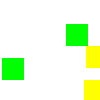

In [797]:
# Example usage
render_trace(Gen.simulate(scene, ()), true);

## Scoring sampled scenes

In [827]:
# Image observation distribution
struct ObservationMixture <: Distribution{Matrix{Vector{Float64}}} end

function Gen.random(::ObservationMixture, X::Matrix{Vector{Float64}})
    # Throw an error since just a scoring fn
    return X
end

function Gen.logpdf(::ObservationMixture,
        Y::Matrix{Vector{Float64}},
        X::Matrix{Vector{Float64}})

    blank = fill([1.0,1.0,1.0], size(X))
    input_non_background_mask = .!(X .== blank)
    obs_non_background_mask = .!(Y .== blank)

    obs_non_background = Y[input_non_background_mask]
    input_non_background = X[input_non_background_mask]

    # Use IOU (intersection over union) as score
    intersection = sum(obs_non_background .== input_non_background)
    union = sum(obs_non_background_mask .| input_non_background_mask)
    return log(intersection) - log(union)
end

function obs_score(obs, gen)
    return logpdf(ObservationMixture(), obs, gen)
end

(o::ObservationMixture)(arg) = Gen.random(o, arg)

In [826]:
obs_mixture = ObservationMixture()
foo = render(scene())
foo2 = render(scene())
_ = obs_mixture(foo)
print("Sanity checking score fn: ", exp(logpdf(obs_mixture, foo,  foo)))

Sanity checking score fn: 1.0

## Inference procedure

In [801]:
# Inference display utils
function render_samples(traces, log_weights)
    normalized_log_weights = log_weights .- logsumexp(log_weights)
    sample_weights = exp.(normalized_log_weights)
    cum_sampled_scene = render(traces[1][:latents]) * sample_weights[1]
    for i=2:length(traces)
        sampled_scene = render(traces[i][:latents]) * sample_weights[i]
        cum_sampled_scene += sampled_scene
    end
    return cum_sampled_scene
end

render_samples (generic function with 1 method)

In [802]:
# MAP estimate of paramters (ML since uniform)
function get_ml_trace(traces, log_weights)
    log_weights = log_weights .- logsumexp(log_weights)
    weight_sort_perm = sortperm(log_weights, rev=true)
    sorted_weights = log_weights[weight_sort_perm]
    sorted_traces = traces[weight_sort_perm]
    return sorted_traces[1], sorted_weights[1]
end

get_ml_trace (generic function with 1 method)

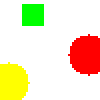

In [809]:
obs_trace, _ = generate(scene, (), Gen.choicemap())
obs = render_trace(obs_trace);
to_display_img(obs)

In [810]:
# Example inference procedure
function do_importance_sample(model, constraints, num_iter)
    (traces, weights, _) = Gen.importance_sampling(model, (), constraints, num_iter);
    return traces, weights
end;

In [815]:
constraints = Gen.choicemap()
constraints[:obs] = obs
traces, weights = do_importance_sample(render_model, constraints, 100000);

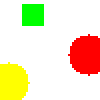

In [816]:
to_display_img(obs)

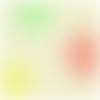

In [817]:
to_display_img(render_samples(traces, weights))

P(obs|latent*) 0.7074626865671646


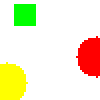

In [830]:
best_trace, best_weight = get_ml_trace(traces, weights)
println("P(obs|latent*) ", exp(obs_score(obs, render(best_trace[:latents]))))
to_display_img(render_samples([best_trace,], [best_weight,]))

### Experimenting w/ constraints

In [831]:
constraints = Gen.choicemap()
constraints[:obs] = obs
constraints[:latents => :n_objects] = obs_trace[:n_objects]
for i in 1:obs_trace[:n_objects]+1
    constraints[:latents => (:shape, i)] = obs_trace[(:shape, i)]
    constraints[:latents => (:color, i)] = obs_trace[(:color, i)]
end

traces, weights = do_importance_sample(render_model, constraints, 100000);

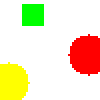

In [832]:
to_display_img(obs)

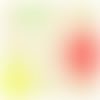

In [821]:
to_display_img(render_samples(traces, weights))

P(obs|latent*) 0.7074626865671646


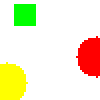

In [829]:
best_trace, best_weight = get_ml_trace(traces, weights)
println("P(obs|latent*) ", exp(obs_score(obs, render(best_trace[:latents]))))
to_display_img(render_samples([best_trace,], [best_weight,]))

## MCMC

In [902]:
function get_unconstrained_vars(vars, constraints)
    valid_vars = []
    for var in vars
        if !Gen.has_value(constraints, var)
            push!(valid_vars, var)
        end
    end
    return valid_vars
end

get_unconstrained_vars (generic function with 1 method)

In [952]:
# Just to get started, doing unconditional resimulation
function block_resimulation_update(tr, constraints)
    # Block 1: Update the number of objects
    n_object_valid = get_unconstrained_vars((:latents => :n_objects, ), constraints)
    (tr, _) = mh(tr, select(n_object_valid...))
    
    # Block 2: Update categorical (i.e. shape & color)
    n = length(tr[:latents])
    for i=1:n
        shape_color_valid = get_unconstrained_vars(
            (
                :latents => (:shape, i),
                :latents => (:color, i),),
            constraints
        )
        (tr, _) = mh(tr, select(shape_color_valid...))
    end

    # Block to change the position
    n = length(tr[:latents])
    for i=1:n
        (tr, _) = mh(tr, select(
                :latents => (:x, i),
                :latents => (:y, i),))
    end
    
    # Return the updated trace
    tr
end;


In [956]:
# Just to get started, doing unconditional resimulation
MAX_DRIFT = 2
@gen function position_proposal(current_trace, i)
    cur_x = current_trace[:latents => (:x, i)]
    cur_y = current_trace[:latents => (:y, i)]
    
    new_x_min = max(cur_x-MAX_DRIFT, 1)
    new_x_max = min(cur_x+MAX_DRIFT, IMG_SIZE)
    new_y_min = max(cur_y-MAX_DRIFT, 1)
    new_y_max = min(cur_y+MAX_DRIFT, IMG_SIZE)
    
    x = {:latents => (:x, i)} ~ uniform_discrete(new_x_min, new_x_max)
    y = {:latents => (:y, i)} ~ uniform_discrete(new_y_min, new_y_max)
end;

function block_drift_update(tr, constraints)
    # Block 1: Update the number of objects
    n_object_valid = get_unconstrained_vars((:latents => :n_objects, ), constraints)
    (tr, _) = mh(tr, select(n_object_valid...))
    
    # Block 2: Update categorical (i.e. shape & color)
    n = length(tr[:latents])
    for i=1:n
        shape_color_valid = get_unconstrained_vars(
            (
                :latents => (:shape, i),
                :latents => (:color, i),),
            constraints
        )
        (tr, _) = mh(tr, select(shape_color_valid...))
    end

    # Update block positions
    n = length(tr[:latents])
    for i=1:n
        (tr, _) = mh(tr, position_proposal, (i,))
    end
    
    # Return the updated trace
    tr
end;


Obs: 


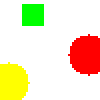

MCMC: 


[ Info: Saved animation to /Users/zackankner/Desktop/ai/PerceptToWorldModel/ppl/tmp.gif


Plots.AnimatedGif("/Users/zackankner/Desktop/ai/PerceptToWorldModel/ppl/tmp.gif")
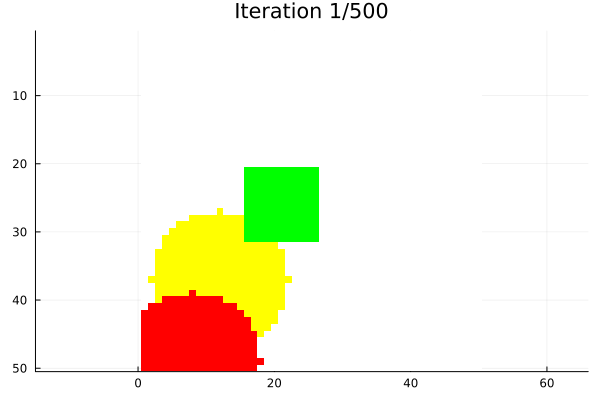

In [954]:
# MCMC visualization util
constraints = Gen.choicemap()
constraints[:obs] = obs
constraints[:latents => :n_objects] = obs_trace[:n_objects]
for i in 1:obs_trace[:n_objects]+1
    constraints[:latents => (:shape, i)] = obs_trace[(:shape, i)]
    constraints[:latents => (:color, i)] = obs_trace[(:color, i)]
end

println("Obs: ")
display(to_display_img(obs))
println("MCMC: ")
t, = generate(render_model, (), constraints)
num_iter = 500
viz = Plots.@animate for i in 1:num_iter
    global t
    t = block_resimulation_update(t, constraints)
    plot(to_display_img(render(t[:latents])), title="Iteration $i/$num_iter")
end;
gif(viz)

Obs: 


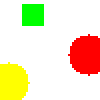

MCMC: 


[ Info: Saved animation to /Users/zackankner/Desktop/ai/PerceptToWorldModel/ppl/tmp.gif


Plots.AnimatedGif("/Users/zackankner/Desktop/ai/PerceptToWorldModel/ppl/tmp.gif")
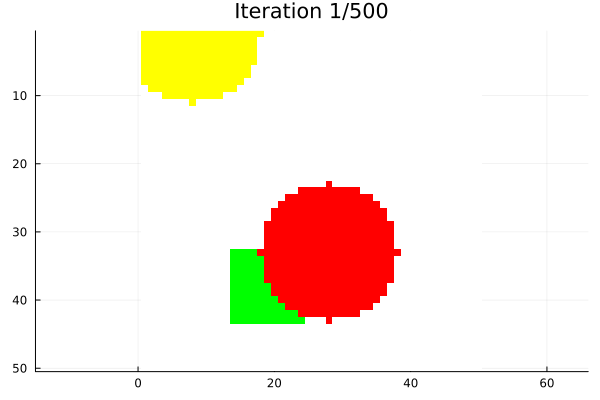

In [957]:
# MCMC visualization util
constraints = Gen.choicemap()
constraints[:obs] = obs
constraints[:latents => :n_objects] = obs_trace[:n_objects]
for i in 1:obs_trace[:n_objects]+1
    constraints[:latents => (:shape, i)] = obs_trace[(:shape, i)]
    constraints[:latents => (:color, i)] = obs_trace[(:color, i)]
end

println("Obs: ")
display(to_display_img(obs))
println("MCMC: ")
t, = generate(render_model, (), constraints)

num_iter = 500
viz = Plots.@animate for i in 1:num_iter
    global t
    t = block_drift_update(t, constraints)
    plot(to_display_img(render(t[:latents])), title="Iteration $i/$num_iter")
end;
gif(viz)

## SMC

In [726]:
function particle_filter(model, num_particles::Int, constraints, num_steps::Int, num_samples::Int)

    # Initialize particles
    state = Gen.initialize_particle_filter(model, (), constraints, num_particles)
    
    # steps
    for t=1:num_steps
        Gen.maybe_resample!(state, ess_threshold=num_particles/2)
        # obs = Gen.choicemap(((:z, t), zs[t+1]))
        Gen.particle_filter_step!(state, (), (UnknownChange(),), Gen.choicemap())
    end
    
    # return a sample of unweighted traces from the weighted collection
    return Gen.sample_unweighted_traces(state, num_samples)
end;

In [739]:
constraints = Gen.choicemap()
constraints[:obs] = obs

constraints[:latents => :n_objects] = obs_trace[:n_objects]
for i in 1:obs_trace[:n_objects]+1
    constraints[:latents => (:shape, i)] = obs_trace[(:shape, i)]
    constraints[:latents => (:color, i)] = obs_trace[(:color, i)]
end

traces = particle_filter(render_model, 100, constraints, 1000, 10);

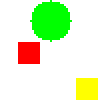

In [740]:
to_display_img(obs)

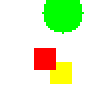

In [741]:
to_display_img(render(traces[9][:latents]))